In [1]:
from __future__ import division
from __future__ import print_function

import matplotlib

import pandas

import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn import tree
import pydotplus 

import scipy
from scipy import sqrt

import sys
sys.path.append('./modules/')
from Processors import *

## Skim size, Acceptance, xSec and luminosity

In [2]:
luminosity = 100

signalFullSize = [50000, 50000, 49600, 50000, 50000, 50000, 100000, 100000, 100000, 99800]
signalSkimSize = [403, 394, 390, 372, 479, 655, 1619, 1858, 2008, 2239]
signalXSec = [2.4524985139, 3.2882620826, 3.8318006272, 4.5185294336, 4.9327584051,
              5.6041453978, 5.7246882202, 5.6830461542, 5.5990314598, 5.3528318771]
signalAcceptance = [a/b for a,b in zip(signalSkimSize, signalFullSize)]

allSignalFullSize = sum(signalFullSize)
allSignalSkimSize = sum(signalSkimSize)
allSignalAcceptance = allSignalSkimSize/allSignalFullSize

backgroundFullSize = [92925926, 47502020]
backgroundSkimSize = [166157, 1896]
backgroundXSec = [816, 61526.7]
backgroundAcceptance = [a/b for a,b in zip(backgroundSkimSize, backgroundFullSize)]

allBackgroundFullSize = sum(backgroundFullSize)
allBackgroundSkimSize = sum(backgroundSkimSize)
allBackGroundAcceptance = allBackgroundSkimSize/allBackgroundFullSize

### Calculate significância

In [3]:
def SignalSignificanceSelector(SignalSignificance):
    temp = sorted(SignalSignificance)[0:min(len(SignalSignificance), 3)]
    return sum(temp)/len(temp)

def calculateFOM(Signals, Backgounds, signalIdx, backgroundIdx, minimum=False):
    s_signal, s_background = [], 0
    for i, signal in enumerate(Signals):
        s_signal.append(len(signal) * signalXSec[signalIdx[i]] / signalFullSize[signalIdx[i]] * luminosity)
    
    for i, background in enumerate(Backgounds):
        s_background += len(background) * backgroundXSec[backgroundIdx[i]] / backgroundFullSize[backgroundIdx[i]] * luminosity
    
    if s_background != 0:
        return SignalSignificanceSelector(s_signal) / sqrt(s_background)
    else:
        return -1

In [4]:
def mergeDataFrame(data):
    allData = data[0]
    for _data in data[1:]:
        allData = allData.append(_data, ignore_index=True)
    return allData

In [5]:
loc = './Data/'

masses = [260, 270, 280, 300, 320, 400, 500, 550, 600, 700]
backgroundLabels = ['TT', 'WJets']

signalData = []
backgroundData = []

for mass in masses:
    signalData.append(pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + 
                                      str(mass) + "_narrow_13TeV-madgraph.csv"))

# same as 2 but only the first half of the events
#backgroundData.append(pandas.read_csv(loc + "TT_TuneCUETP8M1_13TeV-powheg-pythia8_1.csv"))
backgroundData.append(pandas.read_csv(loc + "TT_TuneCUETP8M1_13TeV-powheg-pythia8_2.csv"))
backgroundData.append(pandas.read_csv(loc + "WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.csv"))


# drop columns without header
for mass, signal_data in zip(masses, signalData):
    signal_data.drop([x for x in signal_data.columns if 'Unnamed' in x], axis=1, inplace=True)
    signal_data['gen_label'] = str(mass)

for label, background_data in zip(backgroundLabels, backgroundData):
    background_data.drop([x for x in background_data.columns if 'Unnamed' in x], axis=1, inplace=True)
    background_data['gen_label'] = label

allSignalData = mergeDataFrame(signalData)
allBackgroundData = mergeDataFrame(backgroundData)

for i in range(len(masses)):
    print("{} events for Higgs with {} GeV".format(len(signalData[i]), masses[i]))
print("{} TT_Tune events".format(len(backgroundData[0])))
print("{} WJetsToLNu_Tune events".format(len(backgroundData[1])), end='\n\n')
print("{} events of Higgs".format(len(allSignalData)))
print("{} background events".format(len(allBackgroundData)))

403 events for Higgs with 260 GeV
394 events for Higgs with 270 GeV
390 events for Higgs with 280 GeV
372 events for Higgs with 300 GeV
479 events for Higgs with 320 GeV
655 events for Higgs with 400 GeV
1619 events for Higgs with 500 GeV
1858 events for Higgs with 550 GeV
2008 events for Higgs with 600 GeV
2239 events for Higgs with 700 GeV
166157 TT_Tune events
1896 WJetsToLNu_Tune events

10417 events of Higgs
168053 background events


In [6]:
dropMctMatch = True

if dropMctMatch:
    # drop signal that does not match thing
    allSignalData = allSignalData[allSignalData['gen_mctMatch']]

allData = allSignalData.append(allBackgroundData, ignore_index=True)
allLabels = np.append(np.ones(len(allSignalData)),np.zeros(len(allBackgroundData)))

In [7]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH']

for p in particles:
    moveToCartesian(allData, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    addEnergy(allData, p) #Calculate energy and absolute momentum
    
moveToCartesian(allData, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(allData, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(allData, allData['t_1_pT'], allData['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu

## select train variables

In [8]:
genFeatures = [var for var in allData.columns if str.startswith(var, "gen")] #Generator features; not for training
trainFeatures = [var for var in allData.columns if var not in genFeatures] #Reconstructed features; ok for training

In [9]:
pTEtaPhi = [var for var in trainFeatures for x in ['phi', 't_1_mass'] if x in var] # 'pT', 'eta', 
other = [var for var in trainFeatures for x in ['diH_kinFit_prob'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi + other]

In [10]:
fsFeatures = [var for var in trainFeatures for p in particles + ['mPT'] if p in var]
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']

In [11]:
classTrainFeatures = fsFeatures
print("Training on {} features {}". format(len(classTrainFeatures), classTrainFeatures))

Training on 64 features ['t_0_pT', 't_0_eta', 't_0_mass', 't_1_pT', 't_1_eta', 'b_0_pT', 'b_0_eta', 'b_0_mass', 'b_0_csv', 'b_1_pT', 'b_1_eta', 'b_1_mass', 'b_1_csv', 'mPT_pT', 'h_tt_pT', 'h_tt_eta', 'h_tt_mass', 'h_tt_svFit_mass', 'h_bb_pT', 'h_bb_eta', 'h_bb_mass', 'diH_pT', 'diH_eta', 'diH_mass', 'diH_kinFit_mass', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT']


In [12]:
removeFromTrain = [700]

allDataTrainFeatures = allData

for remove in removeFromTrain:
    allLabels = allLabels[allDataTrainFeatures['gen_label'] != str(remove)]
    allDataTrainFeatures = allDataTrainFeatures[allDataTrainFeatures['gen_label'] != str(remove)]

allDataTrainFeatures = allDataTrainFeatures[classTrainFeatures]

X_train, X_test, y_train, y_test = train_test_split(allDataTrainFeatures, allLabels, test_size=0.2, random_state=2345)
for var in (X_train, X_test):
    var.reset_index(inplace=True, drop=True)

## Remove points who fail conversion to float32

In [13]:
def cleanData(X, y):
    """
    Recives data and labels (X and y)
    
    Returns: X, y after removing points that would fail to convert to float32 
    """
    over  = (X > np.finfo(np.float32).max)
    under = (X < np.finfo(np.float32).min)
    selecting = pandas.Series(np.zeros(len(X)), dtype=np.bool)

    for label in over.columns:
        selecting = selecting | over[label] | under[label]
    
    y = y[np.logical_not(selecting)]#.astype('float32')
    X = X[np.logical_not(selecting)].reset_index(drop=True)#.values.astype('float32')
    
    return X, y

In [14]:
X_train, y_train = cleanData(X_train, y_train)
X_test , y_test  = cleanData(X_test , y_test )

In [15]:
scale = len(allBackgroundData)/len(allSignalData)

weights_train = np.ones(len(y_train))
weights_test = np.ones(len(y_test))

weights_train[y_train == 1] = scale
weights_test[y_test == 1] = scale

In [16]:
%%time
# fit model on training data
model = xgb.XGBClassifier(random_state=1337, silent=False,
                          scale_pos_weight=scale,
                          objective='binary:logistic',
                          n_estimators=100, eval_metric='auc',
                          max_depth=4,
                          n_jobs=8) #NOTE: number os threads to execute
model.fit(X_train, y_train)

CPU times: user 3min 21s, sys: 200 ms, total: 3min 21s
Wall time: 25.7 s


In [17]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [18]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy           : {:10}%".format(accuracy * 100.0))

accuracy = accuracy_score(y_test, predictions, sample_weight=y_test)
print("Accuracy signal    : {:10}%".format(accuracy * 100.0))

accuracy = accuracy_score(y_test, predictions, sample_weight=np.logical_not(y_test))
print("Accuracy background: {:10}%".format(accuracy * 100.0))

Accuracy           : 95.76591782097545%
Accuracy signal    : 91.56118143459916%
Accuracy background: 95.85475291950198%


In [19]:
print(model.score(X_train, y_train, sample_weight=weights_train))
print(model.score(X_test, y_test, sample_weight=weights_test))

0.964241706224
0.940533493299


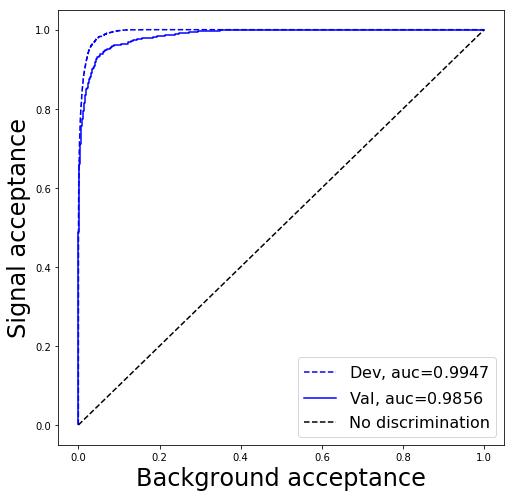

In [20]:
from sklearn import metrics

plt.figure(figsize=[8, 8])
plt.plot(*metrics.roc_curve(y_train, model.predict_proba(X_train)[:,1])[:2],
         label=r'Dev, auc=${:.4f}$'.format(metrics.roc_auc_score(y_train, model.predict_proba(X_train)[:,1])),
         color='b', linestyle='dashed')
plt.plot(*metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])[:2], 
         label=r'Val, auc=${:.4f}$'.format(metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])),
         color='b')
plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)
plt.show()

In [21]:
backgroundTestData, signalTestData = [], []
backgroundScore, signalScore = [], []

for label in backgroundLabels:
    selection = allData['gen_label'] == label
    var = allData[selection]
    
    backgroundTestData.append(var)
    backgroundScore.append(model.predict_proba(var[classTrainFeatures])[:,1])

for mass in masses:
    selection = allData['gen_label'] == str(mass)
    var = allData[selection]
    
    signalTestData.append(var)
    signalScore.append(model.predict_proba(var[classTrainFeatures])[:,1])
    print(mass, np.average(model.predict_proba(var[classTrainFeatures])[:,1]))

260 0.821889
270 0.814594
280 0.785524
300 0.723097
320 0.725862
400 0.785333
500 0.944412
550 0.964521
600 0.971352
700 0.936069


In [22]:
def FOMAfterCut(p):
    cutSignal, cutBackground = [], []
    for data, scores in zip(signalTestData, signalScore):
        cutSignal.append(data[(scores > p)])
    for data, scores in zip(backgroundTestData, backgroundScore):
        cutBackground.append(data[(scores > p)])

    return calculateFOM(cutSignal, cutBackground, range(len(cutSignal)), range(len(cutBackground)))

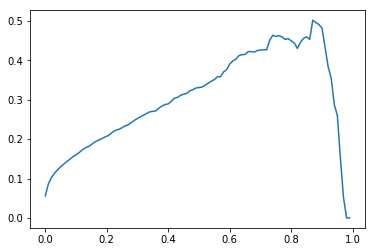

In [23]:
# this is cheating!!!
x = np.linspace(0,.99,100)
y = []
for i in x:
    y.append(FOMAfterCut(i))

plt.plot(x, y)
plt.show()

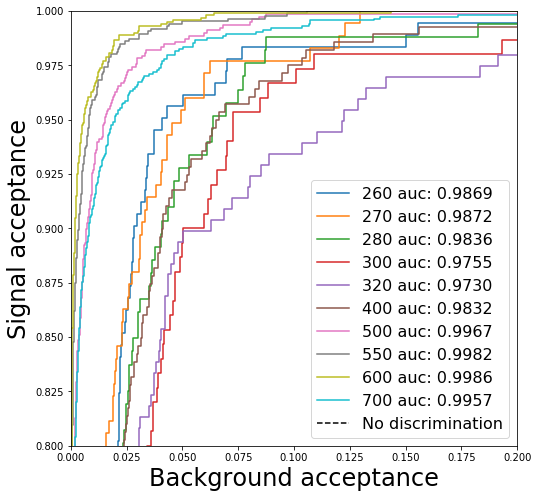

In [24]:
plt.figure(figsize=[8, 8])
# only working for dropMctMatch = True

for mass, signal in zip(masses, signalTestData):
    # requires gen_mctMatch to be false for background
    signalAndBackground = mergeDataFrame(backgroundTestData + [signal])
    
    plt.plot(*metrics.roc_curve(signalAndBackground['gen_mctMatch'], model.predict_proba(signalAndBackground[classTrainFeatures])[:,1])[:2],
             label=str(mass) + ' auc: {:.4f}'.format(
             metrics.roc_auc_score(signalAndBackground['gen_mctMatch'], model.predict_proba(signalAndBackground[classTrainFeatures])[:,1])))

plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)
plt.xlim(0.,0.2)
plt.ylim(0.8,1.)
plt.show()

In [25]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import make_scorer
#asd = GridSearchCV(model, {'max_depth': range(1,7)}, verbose=2, n_jobs=1, scoring=make_scorer(metrics.roc_auc_score))

#asd.fit(X_train, y_train)

In [26]:
#asd.cv_results_

In [27]:
#plt.plot(asd.cv_results_['param_max_depth'].data,
#         asd.cv_results_['mean_test_score'])
#plt.plot(asd.cv_results_['param_max_depth'].data,
#         asd.cv_results_['mean_train_score'])
#plt.show()